In [4]:
# Se importan las librerias que se van a utilizar
import pandas as pd
import talib
import time
import mplfinance as mpf
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# Se elige el PAR
PAIR = 'USDJPY' 

# Lee el archivo CSV
df = pd.read_csv(f"data/{PAIR}/{PAIR}_Candlestick_5_m_BID_01.01.2023-31.07.2023.csv", sep="," )

# Se renombra las columnas del DataFrame
df.columns = ["DateTime", "Open", "High", "Low", "Close", "Volume"]

# Se eliminan los valores NaN
df = df.dropna(subset=['Close'], how='any')

# Se seleccionan los datos con volumen
df_filtered = df[df['Volume'] != 0]

# Se carga en HISTORICAL_DATA_AUX 
historical_data_aux = df_filtered.reset_index(drop=True).copy()

# Los primeros 320 datos se usan para calculos posteriores, como el VAR, o las operaciones de entramiento, por eso se tienen que quitar esos primeros datos
historical_data = historical_data_aux[320:]
historical_data.reset_index(drop=True, inplace=True)
historical_data.head()

,DateTime,Open,High,Low,Close,Volume
0,03.01.2023 00:50:00.000,130.723,130.741,130.639,130.639,949.91
1,03.01.2023 00:55:00.000,130.639,130.642,130.570,130.606,984.92
2,03.01.2023 01:00:00.000,130.612,130.677,130.612,130.659,1078.22
3,03.01.2023 01:05:00.000,130.659,130.714,130.578,130.628,1477.32
4,03.01.2023 01:10:00.000,130.626,130.630,130.198,130.209,2890.75


In [10]:
start_time = time.time()

# Se copia el mismo dataframe para tenerlo con el indice de DateTime indexado y con las columnas como float para más adelante usarlo para las gráficas
hd_index_float = historical_data.copy()
hd_index_float['DateTime'] = pd.to_datetime(hd_index_float['DateTime'])
hd_index_float = hd_index_float.set_index('DateTime')

# Convertir a float las columnas
hd_index_float['Open'] = hd_index_float['Open'].astype(float)
hd_index_float['High'] = hd_index_float['High'].astype(float)
hd_index_float['Low'] = hd_index_float['Low'].astype(float)
hd_index_float['Close'] = hd_index_float['Close'].astype(float)

### Se inicializan las variables
close_data = historical_data['Close']
rsi_data = talib.RSI(close_data, timeperiod=14) # devuelve una serie de pandas
sell_threshold = 70 # Limites para el RSI
buy_threshold = 30 # Limites para el RSI
position = 0 # Posicion incial
entry_price = 0 # Precio inicial a 0
signals = []
initial_balance = 100000
balance = initial_balance # Balance inicial que se irá actualizando
pip = 0.01
stop_loss = 10*pip # Se define un SL fijo
take_profit = 20*pip # Igual con el TP es fijo
risk = 1 # Se define el riesgo como el 1% de balance
transactions = pd.DataFrame(columns=['DateTime','Action','Price']) # Se guardaran todas las transacciones
position_history = pd.DataFrame(columns=['DateTime','Position']) # Aqui se guardara todo el resgitro de los distintos movimientos
balance_history = pd.DataFrame(columns=['DateTime','Balance_history','Action']) # Aqui se llevará el registro del balance

# Inicia el balance
balance_history = pd.concat([balance_history, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[0]], 'Balance_history':[balance],'Action': ['Start']})], ignore_index=True)


#   0 - Fuera del mercado
#   1 - Compra
#  -1 - Venta
#   2 - SL Compra
#  -2 - SL Venta
#   3 - TP Compra
#  -3 - TP Venta
#  10 - Hold de compra 
# -10 - Hold de Venta

### Estrategia de Trading ###
for i in range(len(close_data)):
    
    # Si se está fuera de mercado (0), o en TP (3,-3) o en SL (2,-2) entonces:
    if position in [0, 2, 3, -2, -3]:
        # Si se cumple la condición se entra en COMPRA
        if rsi_data.iloc[i] <= buy_threshold:
            # SE ENTRA EN COMPRA
            # Se define la posición en Compra, y se marca en position, en signals, y se marca el precio de entrada
            position = 1
            signals.append(1)
            entry_price = close_data.iloc[i]
            # Se coloca SL y TP           
            stop_loss_price = round((float(entry_price) - stop_loss),3)
            take_profit_price = round((float(entry_price) + take_profit),3)
            # Se guarda el registro
            transactions = pd.concat([transactions, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]], 'Action': ['Buy'], 'Price': [entry_price]})], ignore_index=True)
            position_history = pd.concat([position_history, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]], 'Position': [1]})], ignore_index=True)

        # Si se cumple la condición se entra en VENTA
        elif rsi_data.iloc[i] >= sell_threshold:
            # SE ENTRA EN VENTA
            # Se define la posición en Venta, y se marca en position, en signals, y el precio de entrada
            position = -1 
            signals.append(-1)
            entry_price = close_data.iloc[i]
            # Se coloca SL y TP
            stop_loss_price = round((float(entry_price) + stop_loss),3)
            take_profit_price = round((float(entry_price) - take_profit),3)
            # Se guarda el registro
            transactions = pd.concat([transactions, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]], 'Action': ['Sell'], 'Price': [entry_price]})], ignore_index=True)
            position_history = pd.concat([position_history, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]], 'Position': [-1]})], ignore_index=True)

        # Si no se cumple ni compra ni venta entonces se mantiene fuera de mercado (0)
        else:
            position = 0
            signals.append(0) 
            transactions = pd.concat([transactions, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]], 'Action': ['Outside_market'], 'Price': [0]})], ignore_index=True)
            position_history = pd.concat([position_history, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]], 'Position': [0]})], ignore_index=True)

    # Si se está en COMPRA, se cierra la posición con take_profit o stop_loss, si no se mantiene
    elif position in [1, 10]:
        # Take Profit de Compra
        if float(close_data.iloc[i]) >= take_profit_price:
            # Se actualiza el balance, position, transactions y position_history
            balance = (initial_balance*(risk*2/100)) + balance
            balance_history = pd.concat([balance_history, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]], 'Balance_history':[balance],'Action': ['Take_Profit_Long']})], ignore_index=True)
            position = 3
            signals.append(3)
            transactions = pd.concat([transactions, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]], 'Action': ['Take_Profit_Long'], 'Price': [close_data.iloc[i]]})], ignore_index=True)
            position_history = pd.concat([position_history, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]], 'Position': [3]})], ignore_index=True)
        # Stop Loss de Compra
        elif float(close_data.iloc[i]) <= stop_loss_price:
            # Se actualiza el balance, position, transactions y position_history
            balance = (initial_balance*(risk*(-1)/100)) + balance
            balance_history = pd.concat([balance_history, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]], 'Balance_history':[balance],'Action': ['Stop_Loss_Long']})], ignore_index=True)
            position = 2
            signals.append(2)
            transactions = pd.concat([transactions, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]], 'Action': ['Stop_Loss_Long'], 'Price': [close_data.iloc[i]]})], ignore_index=True)
            position_history = pd.concat([position_history, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]], 'Position': [2]})], ignore_index=True)
        # Se mantiene la compra
        else:
            position = 10
            signals.append(10)
            transactions = pd.concat([transactions, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]], 'Action': ['Hold_Buy'], 'Price': [close_data.iloc[i]]})], ignore_index=True)
            position_history = pd.concat([position_history, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]], 'Position': [10]})], ignore_index=True)
        

    # Si se está en VENTA, cierre de la posición con take_profit o stop_loss, si no se mantiene
    elif position in [-1, -10]:
        # Take Profit de Venta
        if float(close_data.iloc[i]) <= take_profit_price:
            # Se actualiza el balance, position a -3, transactions y position_history
            balance = (initial_balance*(risk*2/100)) + balance
            balance_history = pd.concat([balance_history, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]],'Balance_history':[balance], 'Action': ['Take_Profit_Short']})], ignore_index=True)            
            position = -3
            signals.append(-3)
            transactions = pd.concat([transactions, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]], 'Action': ['Take_Profit_Short'], 'Price': [close_data.iloc[i]]})], ignore_index=True)
            position_history = pd.concat([position_history, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]], 'Position': [-3]})], ignore_index=True)
        # Stop Loss de Venta
        elif float(close_data.iloc[i]) >= stop_loss_price:
            # Se actualiza el balance, position a -2, transactions y position_history
            balance = (initial_balance*(risk*(-1)/100)) + balance
            balance_history = pd.concat([balance_history, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]],'Balance_history':[balance], 'Action': ['Stop_Loss_Short']})], ignore_index=True)            
            position = -2
            signals.append(-2)
            transactions = pd.concat([transactions, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]], 'Action': ['Stop_Loss_Short'], 'Price': [close_data.iloc[i]]})], ignore_index=True)
            position_history = pd.concat([position_history, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]], 'Position': [-2]})], ignore_index=True)
        # Se mantiene la venta
        else:
            position = -10
            signals.append(-10)
            transactions = pd.concat([transactions, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]], 'Action': ['Hold_Sell'], 'Price': [close_data.iloc[i]]})], ignore_index=True)
            position_history = pd.concat([position_history, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]], 'Position': [-10]})], ignore_index=True)

# Se termina el bucle for, hay que cerrar la posición por si se ha quedado alguna operación abierta
# Si acaba de tocar TP o SL, solo es poner position a 0
if position in [2, 3, -2, -3]:
    position = 0

# Si está en compra
elif position in [1, 10]:
    position = 0
    
    # Se mira la diferencia de pips entre el precio de entrada y actual (último precio) y se divide entre 1 pip, para obtener los pips totales que hay de diferencia
    last_pips = (float(close_data.iloc[-1]) - float(entry_price)) / pip
    # Como se tiene el riesgo (risk que es de 1%) ese es el SL, es decir en este caso es un risk de 1% para 10 pips eso es lo que se ha definido
    # Se saca la relación para ver el riesgo que se tiene para los pips obtenidos
    last_risk = (last_pips*risk) / (stop_loss/pip)
    # Aqui se añade al balance, el last_risk será o negativo o positivo
    balance = (initial_balance*(last_risk/100)) + balance
    
    # Se guarda el registro
    balance_history = pd.concat([balance_history, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]],'Balance_history':[balance],'Action': ['Positive_manual_closing']})], ignore_index=True)            
    
# Si está en venta
elif position in [-1, -10]:
    position = 0
    last_pips = (float(entry_price) - float(close_data.iloc[-1])) / pip
    last_risk = (last_pips*risk) / (stop_loss/pip)
    balance = (initial_balance*(last_risk/100)) + balance
    balance_history = pd.concat([balance_history, pd.DataFrame({'DateTime': [historical_data.DateTime.iloc[i]],'Balance_history':[balance],'Action': ['Negative_manual_closing']})], ignore_index=True)

# Se fija como index el DateTime en balance_history
balance_history = balance_history.set_index('DateTime')

# Se añade la columna Signals al historical_data_index_float para graficar más adelante
hd_index_float['Signals'] = signals

# Cuenta el número de ocurrencias de cada tipo de entrada
tp_count = signals.count(3) + signals.count(-3)
sl_count = signals.count(2) + signals.count(-2)
buy_count = signals.count(1)
sell_count = signals.count(-1)

win_rate = round((tp_count / (tp_count + sl_count)) * 100,2)

# Se crea el DataFrame con los resultados
summary_df = pd.DataFrame({
    'Balance': [balance],
    'Buy': [buy_count],
    'Sell': [sell_count],
    'Take_Profit': [tp_count],
    'Stop_Loss': [sl_count],
    'Win_Rate': [win_rate]
})

end_time = time.time()
execution_time = end_time - start_time

print("Tiempo de ejecución:", execution_time, "segundos")

Tiempo de ejecución: 131.85269045829773 segundos


In [8]:
summary_df

,Balance,Buy,Sell,Take_Profit,Stop_Loss,Win_Rate
0,242310.0,561,588,430,718,37.46


## ------------- Se inicia el ANÁLISIS VISUAL ------------- 

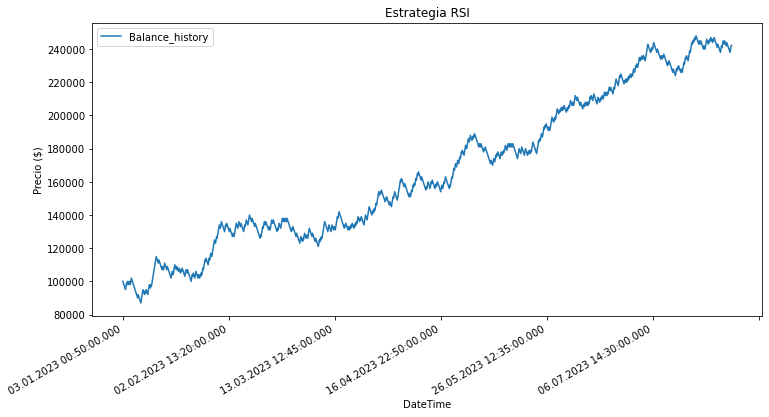

In [53]:
# Crear una figura más grande
plt.figure(figsize=(12, 6))  

# Trazar el gráfico
balance_history['Balance_history'].plot(title="Estrategia RSI")

# Agregar etiqueta al eje y
plt.ylabel('Precio ($)')

# Rotar automáticamente las etiquetas de fecha
plt.gcf().autofmt_xdate()

# Añadir una leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

In [14]:
df_plot = hd_index_float.copy()

# Filtrar por fecha
start_date = pd.to_datetime('2023-03-01 10:30:00')
end_date = pd.to_datetime('2023-03-01 18:40:00')
mask = (df_plot.index >= start_date) & (df_plot.index <= end_date)
df_plot = df_plot.loc[mask]

df_plot

,Open,High,Low,Close,Volume,Signals
DateTime,,,,,,
2023-03-01 10:30:00,130.542,130.622,130.521,130.558,3752.12,0
2023-03-01 10:35:00,130.561,130.587,130.498,130.570,2841.83,0
2023-03-01 10:40:00,130.570,130.635,130.570,130.610,2602.57,0
2023-03-01 10:45:00,130.610,130.674,130.586,130.648,2119.39,0
2023-03-01 10:50:00,130.648,130.680,130.624,130.632,2705.40,0
...,...,...,...,...,...,...
2023-03-01 18:20:00,130.693,130.716,130.665,130.669,1121.24,0
2023-03-01 18:25:00,130.669,130.684,130.600,130.614,1559.80,0
2023-03-01 18:30:00,130.615,130.651,130.608,130.642,835.66,0


<AxesSubplot:title={'center':'historical_data price'}, xlabel='DateTime'>

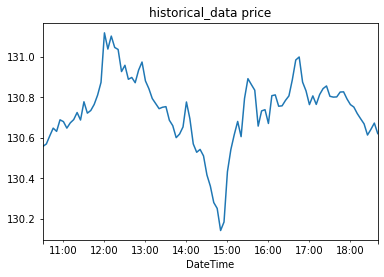

In [15]:
# Visión general del gráfico
df_plot['Close'].plot(title="historical_data price")

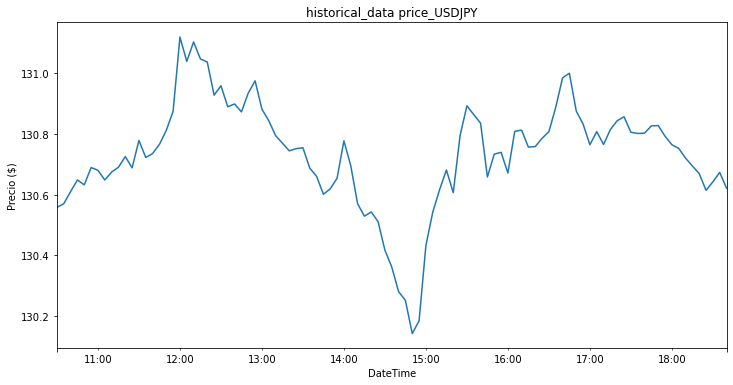

In [17]:
# Crear una figura más grande
plt.figure(figsize=(12, 6))  # Ajusta el tamaño como desees (ancho x alto)

# Trazar el gráfico
df_plot['Close'].plot(title="historical_data price_USDJPY")
# Agregar etiqueta al eje y
plt.ylabel('Precio ($)')
# Mostrar el gráfico
plt.show()

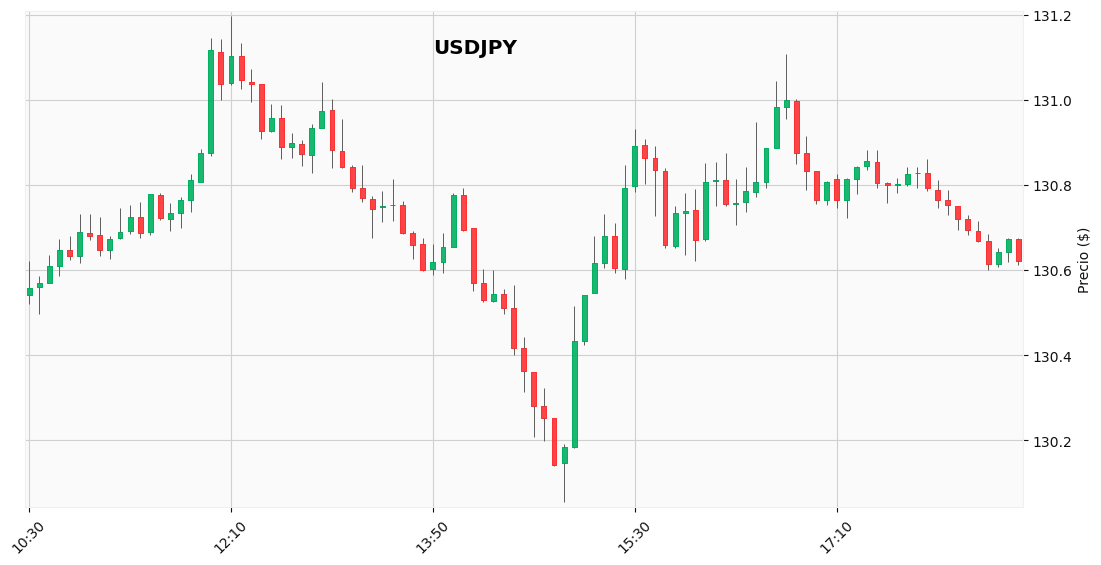

In [23]:
# Visualización de velas japonesas
mpf.plot(df_plot, type='candle', title='USDJPY',ylabel='Precio ($)', style='yahoo',volume=False,
        tight_layout=True,  figratio=(10,5))

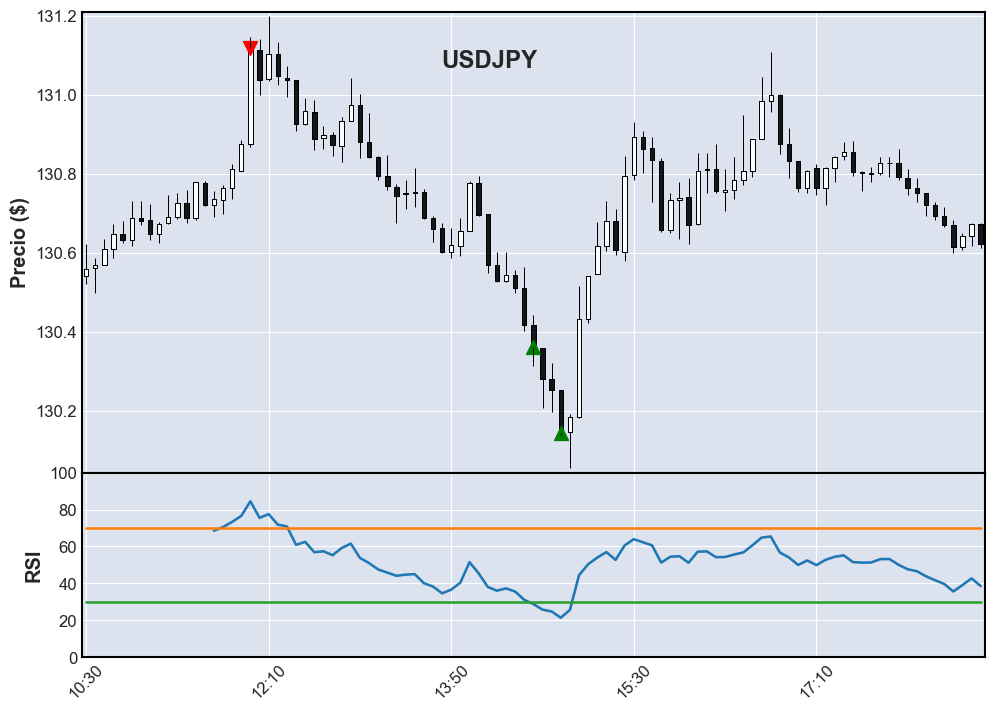

In [32]:
# Dibujamos gráfico + indicador + entradas

# RSI
rsi_data_filtered = talib.RSI(df_plot.Close, timeperiod=14) # devuelve una serie de pandas
# Convertir la serie en un DataFrame
rsi_df = pd.DataFrame(rsi_data_filtered)
# Cambiar el nombre de la columna
rsi_df = rsi_df.rename(columns={0: "RSI"})
rsi_df['sell_threshold']=70
rsi_df['buy_threshold']=30

# Markers
# Indicador de compra
markers_buy = df_plot.loc[:, ['Close','Signals']]
markers_buy['Close'] = markers_buy['Close'].where(markers_buy['Signals'] == 1, np.nan)
markers_buy_list = markers_buy['Close'].tolist()
# Indicador de venta
markers_sell = df_plot.loc[:, ['Close','Signals']]
markers_sell['Close'] = markers_sell['Close'].where(markers_sell['Signals'] == -1, np.nan)
markers_sell_list = markers_sell['Close'].tolist()

plots = [
            mpf.make_addplot(rsi_df[['RSI','sell_threshold','buy_threshold']], ylim=[0, 100], panel=1, ylabel='RSI'),
            mpf.make_addplot(markers_sell_list, type='scatter', marker='v', markersize=100, color = 'red', panel=0),
            mpf.make_addplot(markers_buy_list, type='scatter', marker='^', markersize=100, color = 'green', panel=0)
        ]



mpf.plot(df_plot,
         type='candle', 
         title='USDJPY',
         ylabel='Precio ($)', 
         volume=False,
         tight_layout=True,  
         # figratio=(8,5), 
         addplot=plots,
         # panel_ratios=(3,1), 
         figscale=1.3,
         # style='yahoo',
        # main_panel=0,
        volume_panel=2,
        num_panels=2
        
        )

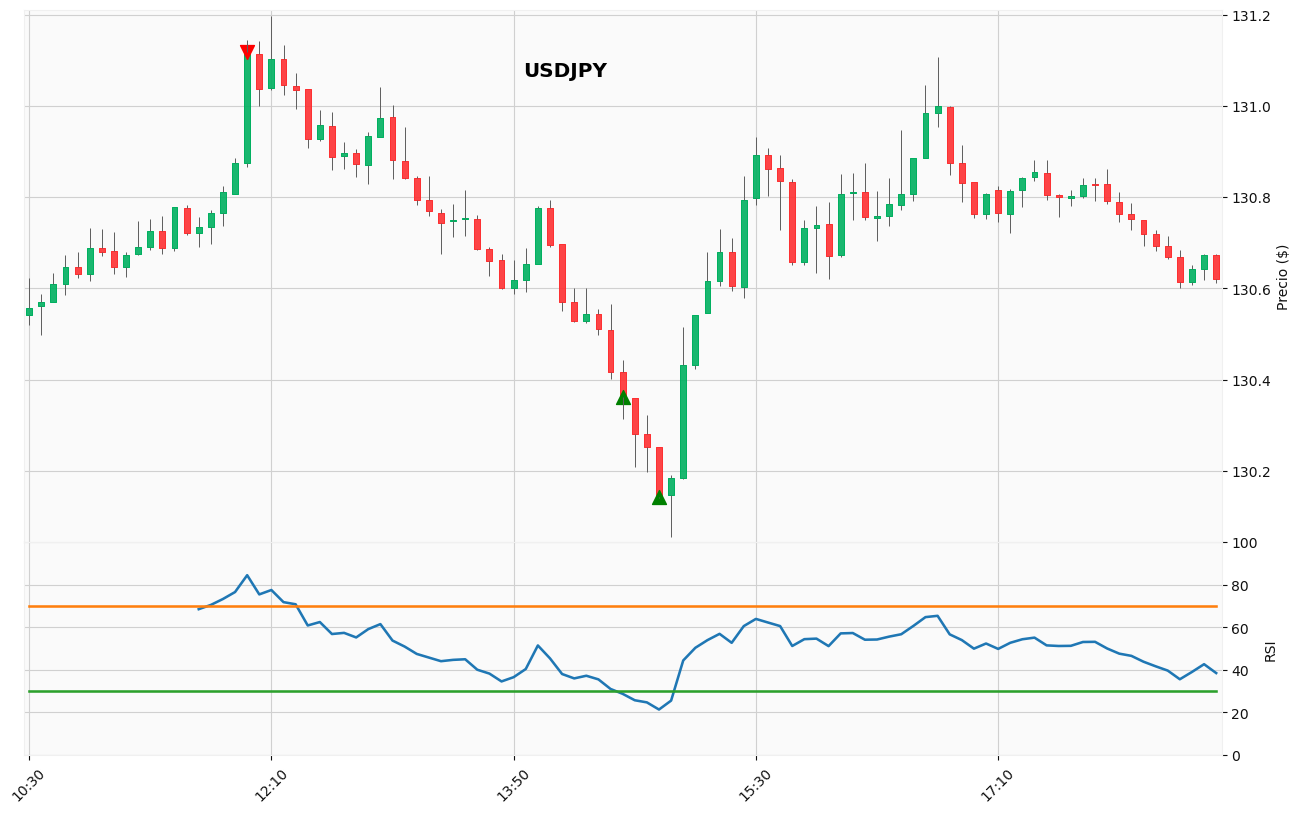

In [33]:
# Dibujamos gráfico + indicador + entradas

# RSI
rsi_data_filtered = talib.RSI(df_plot.Close, timeperiod=14) # devuelve una serie de pandas
# Convertir la serie en un DataFrame
rsi_df = pd.DataFrame(rsi_data_filtered)
# Cambiar el nombre de la columna
rsi_df = rsi_df.rename(columns={0: "RSI"})
rsi_df['sell_threshold']=70
rsi_df['buy_threshold']=30

# Markers
# Indicador de compra
markers_buy = df_plot.loc[:, ['Close','Signals']]
markers_buy['Close'] = markers_buy['Close'].where(markers_buy['Signals'] == 1, np.nan)
markers_buy_list = markers_buy['Close'].tolist()
# Indicador de venta
markers_sell = df_plot.loc[:, ['Close','Signals']]
markers_sell['Close'] = markers_sell['Close'].where(markers_sell['Signals'] == -1, np.nan)
markers_sell_list = markers_sell['Close'].tolist()

plots = [
            mpf.make_addplot(rsi_df[['RSI','sell_threshold','buy_threshold']], ylim=[0, 100], panel=1, ylabel='RSI'),
            mpf.make_addplot(markers_sell_list, type='scatter', marker='v', markersize=100, color = 'red', panel=0),
            mpf.make_addplot(markers_buy_list, type='scatter', marker='^', markersize=100, color = 'green', panel=0)
        ]



mpf.plot(df_plot,
         type='candle', 
         title='USDJPY',
         ylabel='Precio ($)', 
         volume=False,
         tight_layout=True,  
         figratio=(8,5), 
         addplot=plots,
         # panel_ratios=(3,1,1), 
         figscale=1.5,
         style='yahoo',
        # main_panel=0,
        # volume_panel=2,
        # num_panels=2
        
        )